In [1]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.linear_model import BayesianRidge
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import ExtraTreeClassifier
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import lightgbm
import catboost
import xgboost
#import shap
from scipy import interp
#import seaborn as sns
from catboost import *
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
#%matplotlib
###########wrapping root mean square error for later calls##########
def compute_mae_mse_rmse(target,prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)  # target-prediction之差平方
        absError.append(abs(val))  # 误差绝对值
    mae=sum(absError)/len(absError)  # 平均绝对误差MAE
    mse=sum(squaredError)/len(squaredError)  # 均方误差MSE
    RMSE=np.sqrt(sum(squaredError)/len(squaredError))
    R2=r2_score(target,prediction)
    return mae,mse,RMSE,R2
###########loading data##########
fdata=pd.read_csv('database_filled_CD.csv',encoding="gbk")
raw_data=fdata.loc[:,[
                      'Operating Temperature (℃)',#0
                      'Flow Rate (mL min-1)',#1    
                      'Active Area (cm2)', #2
                      'Ir wt. %',#3
                      'Ru wt.%',#4
                      'O wt. %',#5
                      'I/C in Anode',#6
                      'Pt wt. %',#7
                      'I/C in Cathode',#8  
                      'Anode Precious Metal Loading (mg cm-2 Ir/Ru/Pt/Pd)',#9
                      'Cathode Precious Metal Loading (mg cm-2 Pt/Pd)',#10
                      'Membrane Thickness (μm)',#11
                      'EW'#12
                        ]]
###########train test splitting##########
raw_param=raw_data.iloc[:,0:13]
print('ready')

ready


In [2]:
CD18=fdata.loc[:,['Current at 1.8 V']]

In [3]:
def summarize(list1):
    total=0
    for ele in range(0, len(list1)):
        total = total + list1[ele]
    return total

In [4]:
def gridsearch(model,param,algorithm_name):
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-1)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    result = best_model.predict(X_test)
    x_prediction_07=result
    y_real_07=y_test[:,0]
    x_prediction_07_series=pd.Series(x_prediction_07)
    y_real_07_series=pd.Series(y_real_07)
    
    result_train = best_model.predict(X_train)
    x_prediction_07_train=result_train
    y_real_07_train=y_train[:,0]
    x_prediction_07_series_train=pd.Series(x_prediction_07_train)
    y_real_07_series_train=pd.Series(y_real_07_train)
    
    ###########evaluating the regression quality##########
    corr_ann = round(x_prediction_07_series.corr(y_real_07_series), 5)
    error_val= compute_mae_mse_rmse(x_prediction_07,y_real_07)
    
    corr_ann_train = round(x_prediction_07_series_train.corr(y_real_07_series_train), 5)
    error_val_train= compute_mae_mse_rmse(x_prediction_07_train,y_real_07_train)
    
    print(algorithm_name)
    print(best_model.feature_importances_)
    print('Best Regressor:',grid.best_params_,'Best Score:', grid.best_score_)
    print(error_val,'TEST R2',error_val[3],'TEST CORR',corr_ann)
    print(error_val_train,'TRAIN R2',error_val_train[3],'TRAIN CORR',corr_ann_train)
    x_y_x=np.arange(0,4.5,0.1)
    x_y_y=np.arange(0,4.5,0.1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x_prediction_07,y_real_07,color='red',label=algorithm_name+' Test Set',alpha=0.75)
    ax.scatter(x_prediction_07_train,y_real_07_train,color='blue',label=algorithm_name+' Training Set',alpha=0.25,marker="^")
    ax.plot(x_y_x,x_y_y)
    plt.legend()
    plt.xlabel(u"Predicted_Current_Density (mA cm^-2)@1.8V (vs. RHE)")
    plt.ylabel(u"Real_Current_Density (mA cm^-2)@1.8V (vs. RHE)")
    plt.savefig('CD18 SEL %s.png' %algorithm_name)
    print('finished')

In [5]:
seed=7
X_train, X_test, y_train, y_test = train_test_split(raw_param, CD18, test_size=.15,random_state=seed)

In [6]:
train=pd.concat([X_train,y_train],axis=1)
train.to_csv('REG18_train.csv')
test=pd.concat([X_test,y_test],axis=1)
test.to_csv('REG18_test.csv')

In [9]:
from catboost import *
import shap
def shap_plot(model,param,algorithm_name):
    print(algorithm_name)
    SHAP_INPUT=raw_data.iloc[:,0:13]
    SHAP_OUTPUT=CD18
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-100)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    X_SHAP=SHAP_INPUT.values.astype(np.float32)
    y_SHAP=SHAP_OUTPUT
    if algorithm_name=='CatBoost':
        shap_values = best_model.get_feature_importance(Pool(X_SHAP,y_SHAP), type="ShapValues")
        shap_values=shap_values[:,:-1]
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    elif algorithm_name=='Random Forest' or algorithm_name=='Extra Tree'or algorithm_name=='Decision Tree'or algorithm_name=='AdaBoost':
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    else:
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)

In [6]:
# ##########LGBM gridsearch CV for best hyperparameter##########
# model_LightGBMRegressor=lightgbm.LGBMRegressor(random_state=1,verbose=-1)
# param_light = {
# 'boosting_type':['gbdt','rf'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'n_estimators':[50,100,200,400],
# 'max_depth':[5,7,9,11,13,-1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_LightGBMRegressor,param_light,'LightGBM')

# ##########XGBoost gridsearch CV for best hyperparameter##########
# model_XGBRegressor=xgboost.XGBRegressor(objective='reg:squarederror',random_state=1,verbosity=0)
# param_xg = {
# 'booster':['gbtree'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[100,200,400],
# 'max_depth':[5,7,9,11,13],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_XGBRegressor,param_xg,'XGBoost')

# ##########CatBoost gridsearch CV for best hyperparameter##########
# model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
# param_cat = {
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5],
# 'n_estimators':[50,100,200,400],
# "boosting_type":["Plain"],
# 'max_depth':[5,7,9,11],
# 'subsample':[0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_CatRegressor,param_cat,'CatBoost')


# ###########GradientBoost gridsearch CV for best hyperparameter##########
# model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=1)
# ###########defining the parameters dictionary##########
# param_GB = {
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[50,100,200,400],
# 'max_depth':[3,5,7,9,11,13,16],
# 'criterion':['friedman_mse','mae','mse'],
# 'max_features':['auto','sqrt','log2'],
# 'loss':['ls', 'lad', 'huber', 'quantile']
# }
# gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost')

# ###########RandomForest gridsearch CV for best hyperparameter##########
# model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
# ###########defining the parameters dictionary##########
# param_RF = {
# 'n_estimators':[50,100,200,400,None],
# 'max_depth':[3,5,7,9,11,None],
# 'criterion':['mse','mae'],
# 'max_features':['auto','sqrt','log2']
# }
# gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')


# ###########Extra Tree gridsearch CV for best hyperparameter##########
# model_ExtraTreeRegressor = ExtraTreeRegressor(random_state=1)
# param_ET = {
# 'max_depth':[5,6,7,8,9,10,11,None],
# 'max_features':['auto','sqrt','log2'],
# 'criterion' : ["mse", "friedman_mse", "mae"],
# 'splitter' : [ "best",'random']
# }
# gridsearch(model_ExtraTreeRegressor,param_ET,'Extra Tree')


# ###########Decision Tree gridsearch CV for best hyperparameter##########
# model_DecisionTreeRegressor = tree.DecisionTreeRegressor(random_state=1)
# param_DT = {
# 'max_depth':[5,6,7,8,9,10,11,None],
# 'max_features':['auto','sqrt','log2'],
# 'criterion' : ["mse", "friedman_mse", "mae"],
# 'splitter' : [ "best",'random']
# }
# gridsearch(model_DecisionTreeRegressor,param_DT,'Decision Tree')


# ###########AdaBoost gridsearch CV for best hyperparameter##########
# model_AdaBoostRegressor = ensemble.AdaBoostRegressor(random_state=1)
# param_Ada = {
# 'n_estimators':[50,100,200,400,800],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'loss':['linear', 'square', 'exponential']
# }
# gridsearch(model_AdaBoostRegressor,param_Ada,'AdaBoost')

C:\Users\Administratro\AppData\Roaming\Python\Python37\site-packages\lightgbm\basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


LightGBM
[659 308 167 126  71 196 874 251 476 677 354 191 340]
Best Regressor: {'boosting_type': 'gbdt', 'learning_rate': 0.12, 'max_depth': 7, 'n_estimators': 400, 'reg_alpha': 1e-05, 'reg_lambda': 0.01, 'subsample': 0.4} Best Score: 0.7701006614700843
(0.27313314005657413, 0.20526067830709613, 0.45305703648337275, 0.7876064844381613) TEST R2 0.7876064844381613 TEST CORR 0.89899
(0.13368191720535316, 0.08376999989168879, 0.28943047505694486, 0.9183028231565784) TRAIN R2 0.9183028231565784 TRAIN CORR 0.96281
finished


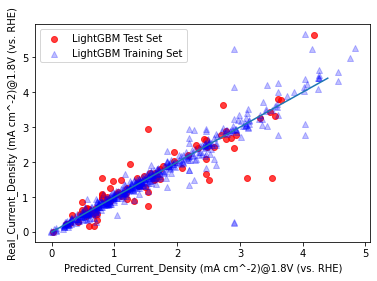

In [7]:
##########LGBM gridsearch CV for best hyperparameter##########
model_LightGBMRegressor=lightgbm.LGBMRegressor(random_state=1,verbose=-1)
param_light = {
'boosting_type':['gbdt'],
'learning_rate':[0.12],
'subsample':[0.4],
'n_estimators':[400],
'max_depth':[7],
'reg_alpha':[1e-05],
'reg_lambda':[0.01]
}
gridsearch(model_LightGBMRegressor,param_light,'LightGBM')

In [10]:
%matplotlib
shap_plot(model_LightGBMRegressor,param_light,'LightGBM')

Using matplotlib backend: Qt5Agg
LightGBM


Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array


[0.32659878 0.06207219 0.04726015 0.03631686 0.0408743  0.06035542
 0.15558546 0.09607129 0.14360003 0.11733244 0.06150173 0.41216919
 0.08455393]


In [11]:
##########XGBoost gridsearch CV for best hyperparameter##########
model_XGBRegressor=xgboost.XGBRegressor(objective='reg:squarederror',random_state=1,verbosity=0)
param_xg = {
'booster':['gbtree'],
'learning_rate':[0.02],
'n_estimators':[200],
'max_depth':[11],
'subsample':[0.4],
'reg_alpha':[0],
'reg_lambda':[1e-05]
}
gridsearch(model_XGBRegressor,param_xg,'XGBoost')

XGBoost
[0.03097785 0.01512896 0.02374061 0.02950398 0.02804396 0.06899851
 0.04631102 0.04680886 0.08590943 0.03729742 0.04529686 0.46310613
 0.07887635]
Best Regressor: {'booster': 'gbtree', 'learning_rate': 0.02, 'max_depth': 11, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1e-05, 'subsample': 0.4} Best Score: 0.7871103833912566
(0.2856444080373988, 0.2269850074100988, 0.4764294359190024, 0.7374804991029209) TEST R2 0.7374804991029209 TEST CORR 0.88539
(0.12443079793777286, 0.06872155628643749, 0.2621479663976768, 0.9292069293175318) TRAIN R2 0.9292069293175318 TRAIN CORR 0.97086
finished


In [12]:
shap_plot(model_XGBRegressor,param_xg,'XGBoost')

XGBoost
[0.28380507 0.04385302 0.05181145 0.03696746 0.02668629 0.04663723
 0.11487045 0.04845284 0.13248036 0.07006722 0.05482466 0.39391575
 0.08819189]


In [13]:
##########CatBoost gridsearch CV for best hyperparameter##########
model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
param_cat = {

'max_depth':[11],
'boosting_type':['Plain'],
'subsample':[0.85],
'reg_lambda':[0.01]
}
gridsearch(model_CatRegressor,param_cat,'CatBoost')

CatBoost
[21.16270931  3.96485448  4.14923847  3.16791796  2.13389324  6.38156108
 10.73232143  4.1143684  11.69981332  6.55223551  6.29387038 15.45295448
  4.19426193]
Best Regressor: {'boosting_type': 'Plain', 'max_depth': 11, 'reg_lambda': 0.01, 'subsample': 0.85} Best Score: -172.69405294131994
(0.28625346354805875, 0.2291093930529781, 0.47865372980159476, 0.7539439523045774) TEST R2 0.7539439523045774 TEST CORR 0.88857
(0.059151270614579594, 0.05554176998390349, 0.23567301496756793, 0.94872401616105) TRAIN R2 0.94872401616105 TRAIN CORR 0.97541
finished


In [14]:
shap_plot(model_CatRegressor,param_cat,'CatBoost')

CatBoost
[0.26252873 0.05833833 0.0482479  0.03168088 0.02925089 0.04345008
 0.12902849 0.04557872 0.12209529 0.06309511 0.08718558 0.27377886
 0.08443888]


In [15]:
###########GradientBoost gridsearch CV for best hyperparameter##########
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=1)
###########defining the parameters dictionary##########
param_GB = {
'learning_rate':[0.1],
'n_estimators':[100],
'max_depth':[5],
'criterion':['friedman_mse'],
'max_features':['sqrt'],
'loss':['ls']
}
gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoost
[0.17387421 0.05545905 0.02685842 0.02592318 0.01150074 0.06335904
 0.15075129 0.02677842 0.08686312 0.05205553 0.0875345  0.18136924
 0.05767326]
Best Regressor: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100} Best Score: 0.7808439154432719
(0.28292614343546435, 0.2009569939878413, 0.4482822704366539, 0.7686637955326603) TEST R2 0.7686637955326603 TEST CORR 0.89936
(0.14639978885749846, 0.0794524309319997, 0.28187307592602684, 0.9201457615980749) TRAIN R2 0.9201457615980749 TRAIN CORR 0.96518
finished


In [16]:
shap_plot(model_GradientBoostingRegressor,param_GB,'GradientBoost')

GradientBoost


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.30194531 0.05476796 0.0539249  0.03614919 0.01776111 0.05162062
 0.12984886 0.06048902 0.10940352 0.07792361 0.06919638 0.29724558
 0.13137304]


In [17]:
###########RandomForest gridsearch CV for best hyperparameter##########
model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
###########defining the parameters dictionary##########
param_RF = {
'n_estimators':[200],
'max_depth':[None],
'criterion':['mae'],
'max_features':['sqrt']
}
gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest
[0.1698075  0.06455354 0.04592815 0.04674506 0.02188419 0.05386286
 0.12169911 0.05455635 0.08733205 0.07346515 0.08000339 0.12681471
 0.05334794]
Best Regressor: {'criterion': 'mae', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200} Best Score: 0.7617597489549566
(0.28818631360189606, 0.1995357757277432, 0.44669427545889057, 0.7357989643627818) TEST R2 0.7357989643627818 TEST CORR 0.90163
(0.15402177560118108, 0.0840300321710379, 0.2898793407109894, 0.9087471522084506) TRAIN R2 0.9087471522084506 TRAIN CORR 0.96494
finished


In [18]:
shap_plot(model_RandomForestRegressor,param_RF,'Random Forest')

Random Forest


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
 93%|=================== | 540/578 [00:14<00:00]       

[0.2364618  0.04581607 0.04001282 0.03246    0.02212185 0.03288172
 0.12289253 0.03770908 0.07588422 0.03861615 0.08766935 0.26475915
 0.09556474]


In [20]:
###########Extra Tree gridsearch CV for best hyperparameter##########
model_ExtraTreeRegressor = ExtraTreeRegressor(random_state=1)
param_ET = {
'max_depth':[10],
'max_features':['auto'],
'criterion' : ["friedman_mse"],
'splitter' : [ 'best']
}
gridsearch(model_ExtraTreeRegressor,param_ET,'Extra Tree')

Extra Tree
[0.18962744 0.01544876 0.024779   0.0044778  0.01558118 0.08516366
 0.08304235 0.01944602 0.16487684 0.02783975 0.00905234 0.33323098
 0.02743388]
Best Regressor: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'auto', 'splitter': 'best'} Best Score: 0.6369283357889417
(0.36170417892648915, 0.32019396379192294, 0.5658568403685891, 0.7188572974972065) TEST R2 0.7188572974972065 TEST CORR 0.85619
(0.1083905219625027, 0.07262618142119792, 0.26949245151060897, 0.9321816613321169) TRAIN R2 0.9321816613321169 TRAIN CORR 0.96772
finished


In [21]:
shap_plot(model_ExtraTreeRegressor,param_ET,'Extra Tree')

Extra Tree
[0.29609457 0.03683325 0.10261936 0.00980782 0.05424582 0.12417041
 0.17843001 0.07633904 0.17774733 0.05039807 0.04907787 0.37187102
 0.06830668]


In [22]:
###########Decision Tree gridsearch CV for best hyperparameter##########
model_DecisionTreeRegressor = tree.DecisionTreeRegressor(random_state=1)
param_DT = {
'max_depth':[10],
'max_features':['auto'],
'criterion' : ["friedman_mse"],
'splitter' : [ 'best']
}
gridsearch(model_DecisionTreeRegressor,param_DT,'Decision Tree')

Decision Tree
[0.18962744 0.01544876 0.024779   0.0044778  0.01558118 0.08516366
 0.08304235 0.01944602 0.16487684 0.02783975 0.00905234 0.33323098
 0.02743388]
Best Regressor: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'auto', 'splitter': 'best'} Best Score: 0.6369283357889417
(0.36170417892648915, 0.32019396379192294, 0.5658568403685891, 0.7188572974972065) TEST R2 0.7188572974972065 TEST CORR 0.85619
(0.1083905219625027, 0.07262618142119792, 0.26949245151060897, 0.9321816613321169) TRAIN R2 0.9321816613321169 TRAIN CORR 0.96772
finished


In [23]:
shap_plot(model_DecisionTreeRegressor,param_DT,'Decision Tree')

Decision Tree
[0.29609457 0.03683325 0.10261936 0.00980782 0.05424582 0.12417041
 0.17843001 0.07633904 0.17774733 0.05039807 0.04907787 0.37187102
 0.06830668]


In [24]:
###########AdaBoost gridsearch CV for best hyperparameter##########
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(random_state=1)
param_Ada = {
'n_estimators':[200],
'learning_rate':[0.2],
'loss':['exponential']
}
gridsearch(model_AdaBoostRegressor,param_Ada,'AdaBoost')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


AdaBoost
[0.16719479 0.01588582 0.00985848 0.03466225 0.00853974 0.04964563
 0.17368349 0.02547352 0.12895548 0.01861366 0.02175715 0.3064403
 0.03928969]
Best Regressor: {'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 200} Best Score: 0.6119179493119888
(0.4958615872875814, 0.38326439034791615, 0.6190835083798599, 0.18533768562222064) TEST R2 0.18533768562222064 TEST CORR 0.8131
(0.4728318903468672, 0.38651403367231973, 0.6217025282820714, 0.23753016647757264) TRAIN R2 0.23753016647757264 TRAIN CORR 0.83065
finished


In [25]:
shap_plot(model_AdaBoostRegressor,param_Ada,'AdaBoost')

AdaBoost


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.19313132 0.04296865 0.01126807 0.0174113  0.01734522 0.03226867
 0.17866821 0.02107449 0.13015365 0.01093077 0.02088712 0.30947939
 0.04803551]
